# **Import Library**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential  # Correct import
from pathlib import Path

# **Load Dataset**

In [2]:
# Load merged dataset lokal
# merged_df = pd.read_csv("merged_books_ratings.csv")

from google.colab import drive
drive.mount('/content/drive')

# Path dataset di Google Drive
file_path = "/content/drive/MyDrive/Dataset/merged_books_ratings.csv"

# Load merged dataset
try:
  merged_df = pd.read_csv(file_path)
  print("Dataset loaded successfully.")
except FileNotFoundError:
  print(f"Error: File not found at {file_path}. Please check the file path.")
except pd.errors.ParserError:
  print(f"Error: Could not parse the file at {file_path}. Please check the file format.")
except Exception as e:
  print(f"An unexpected error occurred: {e}")

Mounted at /content/drive
Dataset loaded successfully.


In [3]:
print(merged_df.head())  # Melihat beberapa baris pertama
print(merged_df.columns)  # Melihat nama kolom


                            Title  \
0  Its Only Art If Its Well Hung!   
1        Dr. Seuss: American Icon   
2        Dr. Seuss: American Icon   
3        Dr. Seuss: American Icon   
4        Dr. Seuss: American Icon   

                                         description           authors  \
0                                            unknown  ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
2  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
3  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
4  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   

                                               image  publisher publishedDate  \
0  http://books.google.com/books/content?id=DykPA...    unknown          1996   
1  http://books.google.com/books/content?id=IjvHQ...  A&C Black    2005-01-01   
2  http://books.google.com/books/content?id=IjvHQ...  A&C Black    2005-01-01   
3  http:

# **Rating Data Filter**

In [4]:
# Tentukan batasan rating sebagai target rekomendasi (misal >= 4)
filtered_df = merged_df[merged_df['review/score'] >= 4]
# Menampilkan hasil DataFrame filtered_df teratas
filtered_df.head()

,Title,description,authors,image,publisher,publishedDate,general_category,Id,User_id,profileName,review/score
0,Its Only Art If Its Well Hung!,unknown,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,unknown,1996,fiction,1882931173,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",4.0
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,A&C Black,2005-01-01,non-fiction,0826414346,A30TK6U7DNS82R,Kevin Killian,5.0
2,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,A&C Black,2005-01-01,non-fiction,0826414346,A3UH4UZ4RSVO82,John Granger,5.0
3,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,A&C Black,2005-01-01,non-fiction,0826414346,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",4.0
4,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,A&C Black,2005-01-01,non-fiction,0826414346,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",4.0


# **User-item Matrix**

In [5]:
print(filtered_df.dtypes)

Title                object
description          object
authors              object
image                object
publisher            object
publishedDate        object
general_category     object
Id                   object
User_id              object
profileName          object
review/score        float64
dtype: object


In [6]:
# Menggabungkan rating untuk buku dengan judul yang sama menggunakan groupby dan agg
filtered_df_grouped = filtered_df.groupby('Title')['review/score'].agg('mean')

# Menampilkan DataFrame yang telah digabungkan
filtered_df_grouped

,review/score
Title,
""" Film technique, "" and, "" Film acting """,4.500000
""" We'll Always Have Paris"": The Definitive Guide to Great Lines from the Movies",5.000000
"""... And Poetry is Born ..."" Russian Classical Poetry",4.000000
"""A Truthful Impression of the Country"": British and American Travel Writing in China, 1880-1949",4.000000
"""A careless word, a needless sinking"": A history of the staggering losses suffered by the U.S. Merchant Marine, both in ships and personnel during World War II",5.000000
...,...
william the vehicle king,5.000000
with an everlasting love,4.947368
work and Motivation,5.000000


In [7]:
# Mengelompokkan data berdasarkan judul dan menghitung rata-rata rating
book_ratings = filtered_df.groupby('Title')['review/score'].mean().reset_index()

# Membuat user-item matrix
book_matrix = book_ratings.pivot_table(index='Title', values='review/score')

# Mengisi nilai NaN dengan 0 (asumsi rating 0 jika tidak ada rating)
book_matrix = book_matrix.fillna(0)

# **Neural Network for Content Based Filtering**

pustaka yang diperlukan diimpor:
- `pandas` dan `numpy` untuk manipulasi data.
- `nltk` untuk pemrosesan teks, khususnya untuk mengunduh stopwords.
- `tensorflow.keras` untuk model pembelajaran mendalam (deep learning).
- `sklearn` untuk pembagian data dan penghitungan metrik.

In [8]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [9]:
# Unduh stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Persiapan Dataset**

In [10]:
# Dataset buku
df = book_ratings

In [11]:
# Ambil kolom yang diperlukan: 'Title' dan 'review/score'
data = df[['Title', 'review/score']]

**Preprocessing Teks**

Fungsi preprocess_text digunakan untuk:

- Mengubah teks menjadi lowercase.
- Memecah teks menjadi token.
- Menghapus stopwords yang tidak relevan untuk analisis.

In [12]:
# Preprocessing teks
stop_words = set(stopwords.words('english'))

In [13]:
def preprocess_text(text):
    # Tokenisasi, lowercase, dan hapus stopwords
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [14]:
# Terapkan preprocessing pada kolom Title
data['cleaned_title'] = data['Title'].apply(preprocess_text)


**Tokenisasi dan Padding**

Mengubah teks menjadi bentuk numerik. Tokenizer digunakan untuk mengubah teks menjadi urutan angka berdasarkan frekuensi kata. Padding diterapkan untuk memastikan setiap urutan memiliki panjang yang sama.

In [15]:
# Tokenisasi judul buku
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['cleaned_title'])
title_sequences = tokenizer.texts_to_sequences(data['cleaned_title'])


In [16]:
# Padding agar semua sequence memiliki panjang yang sama
max_sequence_length = max([len(seq) for seq in title_sequences])
X = pad_sequences(title_sequences, maxlen=max_sequence_length)

**Pembagian Data untuk Pelatihan dan Pengujian**

 Dibagi menjadi set pelatihan dan pengujian menggunakan train_test_split.

In [17]:
# Label rating
y = data['review/score'].values


In [18]:
# Split data untuk pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print("Data siap untuk model NLP!")

Data siap untuk model NLP!


# **Pembuatan Model Neural Network**
Model neural network dibangun menggunakan Keras. Model ini terdiri dari:

- Input Layer: Menyesuaikan panjang urutan setelah padding.
- Embedding Layer: Untuk mewakili kata-kata dalam dimensi yang lebih rendah.
- Flatten Layer: Menyamaratakan hasil embedding untuk diproses lebih lanjut.
- Dense Layer: Untuk membuat prediksi skor rating.
- Output Layer: Dengan fungsi aktivasi linear untuk menghasilkan skor numerik.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

In [21]:
# Model dengan layer embedding untuk memproses teks
model = Sequential([
    Input(shape=(max_sequence_length,)),  # Input sesuai panjang sequence setelah padding
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50, input_length=max_sequence_length),
    Flatten(),  # Menyamaratakan output embedding
    Dense(128, activation='relu'),
    Dense(1, activation='linear')  # Output rating sebagai angka kontinu
])


Kompilasi dengan optimizer Adam dan loss function mean_squared_error untuk masalah regresi.

In [22]:
# Menyusun model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])


EarlyStopping diterapkan untuk menghentikan pelatihan jika model tidak mengalami peningkatan pada data validasi setelah beberapa epoch. Model dilatih menggunakan data pelatihan dengan menerapkan early_stopping untuk menghindari overfitting.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
# Early stopping untuk berhenti jika validasi loss tidak membaik setelah beberapa epoch
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,  # Berapa epoch tanpa perbaikan yang akan ditunggu
                               restore_best_weights=True)  # Mengembalikan bobot terbaik setelah berhenti

# Melatih model dengan early stopping
history = model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])


Epoch 1/1000
4021/4021 [==============================] - 243s 60ms/step - loss: 0.1498 - mae: 0.2861 - val_loss: 0.1163 - val_mae: 0.2860
Epoch 2/1000
4021/4021 [==============================] - 240s 60ms/step - loss: 0.1002 - mae: 0.2490 - val_loss: 0.1219 - val_mae: 0.2881
Epoch 3/1000
4021/4021 [==============================] - 240s 60ms/step - loss: 0.0755 - mae: 0.2098 - val_loss: 0.1308 - val_mae: 0.2802
Epoch 4/1000
4021/4021 [==============================] - 240s 60ms/step - loss: 0.0604 - mae: 0.1823 - val_loss: 0.1394 - val_mae: 0.2998


model dievaluasi menggunakan data uji untuk menghitung loss dan Mean Absolute Error (MAE).

In [24]:
# Evaluasi model di data uji
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")



1006/1006 [==============================] - 2s 2ms/step - loss: 0.1163 - mae: 0.2860
Test Loss: 0.11630860716104507, Test MAE: 0.2860424816608429


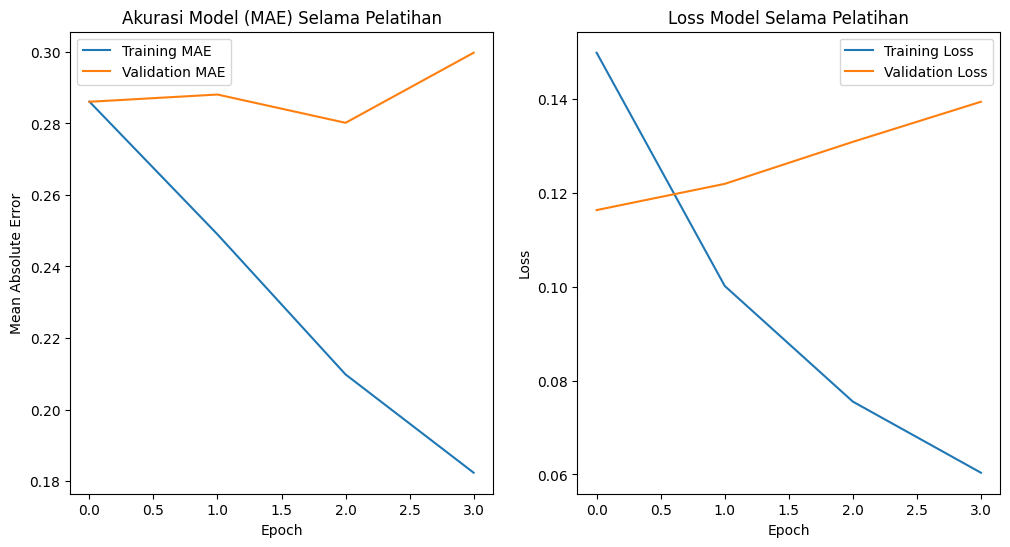

In [25]:
import matplotlib.pyplot as plt

# Plot Akurasi dan Loss untuk Data Latih dan Validasi
plt.figure(figsize=(12, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Akurasi Model (MAE) Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

**Penurunan Training MAE:**

Training MAE terus menurun secara konsisten seiring dengan bertambahnya epoch.
Ini menunjukkan bahwa model sedang belajar dengan baik pada data pelatihan dan semakin mampu memprediksi dengan kesalahan yang lebih kecil.
Fluktuasi Validation MAE:

Validation MAE mengalami fluktuasi. Pada epoch pertama, nilai MAE cukup rendah, namun sedikit meningkat pada epoch berikutnya.
Peningkatan Validation MAE di epoch-epoch selanjutnya (walaupun tidak terlalu signifikan) bisa menjadi indikasi bahwa model mulai overfitting pada data pelatihan. Model belajar terlalu spesifik pada data pelatihan dan kehilangan kemampuan generalisasi pada data validasi.

**Penurunan Training Loss:**

Training loss terus menurun secara konsisten dengan bertambahnya epoch.
Ini menunjukkan bahwa model berhasil mempelajari pola dari data pelatihan dan mampu memprediksi nilai target dengan kesalahan yang semakin kecil.
Fluktuasi Validation Loss:

Validation loss sedikit menurun pada epoch pertama tetapi mulai meningkat pada epoch berikutnya.
Peningkatan Validation Loss, seperti halnya pada Validation MAE, dapat menjadi tanda awal overfitting, karena model belajar terlalu baik pada data pelatihan tetapi tidak mampu generalisasi dengan baik pada data validasi.

In [26]:
# Menampilkan plot
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [33]:
embedding_model = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)  # Output layer embedding
book_embeddings = embedding_model.predict(X)  # X adalah data input untuk model


5026/5026 [==============================] - 7s 1ms/step


Setelah model dilatih, embeddings buku diratakan dan dihitung kemiripannya menggunakan cosine similarity. Matriks kemiripan digunakan untuk menemukan buku yang paling mirip dengan buku tertentu.

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

# Meratakan seluruh embeddings menjadi 2D
book_embeddings_flattened = book_embeddings.reshape(book_embeddings.shape[0], -1)

# Verifikasi bentuk setelah diratakan
print(book_embeddings_flattened.shape)

# Menghitung kemiripan cosine antar buku
cosine_sim = cosine_similarity(book_embeddings_flattened)

# Menampilkan kemiripan antar buku
print("Cosine Similarity Matrix:")
print(cosine_sim)

(160819, 2150)
Cosine Similarity Matrix:
[[0.9999996  0.56145453 0.65189767 ... 0.7096349  0.45571673 0.7200706 ]
 [0.56145453 0.9999999  0.5688794  ... 0.6586975  0.42933056 0.64354306]
 [0.65189767 0.5688794  0.99999976 ... 0.73246324 0.5129166  0.6692809 ]
 ...
 [0.7096349  0.6586975  0.73246324 ... 0.9999994  0.50769854 0.80339   ]
 [0.45571673 0.42933056 0.5129166  ... 0.50769854 0.9999994  0.4682162 ]
 [0.7200706  0.64354306 0.6692809  ... 0.80339    0.4682162  0.99999905]]


In [32]:
# Menampilkan summary model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 43, 50)            3257200   
                                                                 
 flatten (Flatten)           (None, 2150)              0         
                                                                 
 dense (Dense)               (None, 128)               275328    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3532657 (13.48 MB)
Trainable params: 3532657 (13.48 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Fungsi Rekomendasi Buku**
Fungsi get_top_recommendations digunakan untuk mengambil rekomendasi buku berdasarkan judul buku yang diberikan. Buku yang paling mirip dengan buku input akan dikembalikan sebagai rekomendasi, disertai dengan skor kemiripan dan rating review.
**Menampilkan 5 Buku Teratas Berdasarkan Kemiripan dan Rating Tertinggi**

In [35]:
import numpy as np

def get_top_recommendations(book_title, df, cosine_sim, top_n=5):
    # Cek apakah judul buku ada di dataset
    if book_title not in df['Title'].values:
        print(f"Buku dengan judul '{book_title}' tidak ditemukan!")
        return []

    # Menemukan indeks buku berdasarkan judul
    book_idx = df[df['Title'] == book_title].index[0]

    # Verifikasi ukuran cosine_sim
    print(f"Jumlah buku di dataset: {len(df)}")
    print(f"Jumlah baris di cosine_sim: {cosine_sim.shape[0]}")

    # Jika jumlah buku di df tidak sesuai dengan jumlah dalam cosine_sim
    if len(df) != cosine_sim.shape[0]:
        print("Ukuran cosine_sim tidak sesuai dengan dataset!")
        return []

    # Mendapatkan nilai kemiripan untuk buku tersebut
    similarity_scores = cosine_sim[book_idx]

    # Mengurutkan kemiripan dan mengambil indeks dan skor tertinggi
    similar_books_idx = similarity_scores.argsort()[-top_n-1:-1][::-1]  # Mengambil top N rekomendasi (dengan exclude diri sendiri)

    # Menyaring indeks agar tidak termasuk buku itu sendiri
    similar_books_idx = [idx for idx in similar_books_idx if idx != book_idx]

    # Mengambil buku-buku yang relevan
    recommended_books = df.iloc[similar_books_idx]

    # Mengurutkan rekomendasi berdasarkan kolom 'ReviewScore' (skor tertinggi)
    recommended_books = recommended_books.sort_values(by='review/score', ascending=False)

    # Mengembalikan rekomendasi dalam format yang mudah dibaca
    recommendations = []
    for idx, row in recommended_books.iterrows():
        recommendations.append({
            'title': row['Title'],
            'review_score': row['review/score'],
            'Similarity Score': similarity_scores[idx]
        })

    return recommendations



Rekomendasi akan menampilkan 5 rekomendasi buku teratas berdasarkan nilai cosine, dan urutan berdasarkan rating tertinggi

In [36]:
# Contoh: Menampilkan 5 rekomendasi berdasarkan kemiripan untuk buku dengan judul tertentu
book_title = 'Its Only Art If Its Well Hung!'  # Ganti dengan judul buku yang ada di dataset Anda
recommendations = get_top_recommendations(book_title, df, cosine_sim, top_n=5)

# Menampilkan rekomendasi dalam bentuk list ke bawah
print(f"Rekomendasi untuk '{book_title}':")
for idx, rec in enumerate(recommendations, 1):
    print(f"{idx}. {rec}")

Jumlah buku di dataset: 160819
Jumlah baris di cosine_sim: 160819
Rekomendasi untuk 'Its Only Art If Its Well Hung!':
1. {'title': 'The Well, A Novel', 'review_score': 5.0, 'Similarity Score': 0.91188765}
2. {'title': 'Not well advised', 'review_score': 5.0, 'Similarity Score': 0.9019383}
3. {'title': 'Live Well in Honduras', 'review_score': 5.0, 'Similarity Score': 0.910165}
4. {'title': 'The Well of the Worlds', 'review_score': 4.0, 'Similarity Score': 0.91565895}
5. {'title': 'The Well of Time', 'review_score': 4.0, 'Similarity Score': 0.90533566}


# Mengonversi Model TensorFlow ke TensorFlow Lite

**Simpan Model TensorFlow**

In [37]:
# Menyimpan model TensorFlow
model.save('book_recommendation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Mengonversi Model ke Format TensorFlow Lite**

In [ ]:
import tensorflow as tf

# Mengonversi model yang disimpan (.h5) ke format .tflite
model = tf.keras.models.load_model('book_recommendation_model.h5')

# Membuat converter TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengonversi model ke format TFLite
tflite_model = converter.convert()

# Menyimpan model TFLite
with open('book_recommendation_model.tflite', 'wb') as f:
    f.write(tflite_model)


#Neural Network for Colaborative Filtering

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [ ]:
print("Jumlah baris sebelum menghapus duplikasi:", len(ratings_df_complete))

# Hapus duplikasi berdasarkan semua kolom
rating = ratings_df_complete.drop_duplicates()

# Periksa jumlah baris setelah menghapus duplikasi
print("Jumlah baris setelah menghapus duplikasi:", len(rating))

In [ ]:
# mennggunakan 20k darii dataframe rating_df_complete untuk melatih model nya
rating = ratings_df_complete[:20000]
rating.shape

In [ ]:
rating.head()

In [ ]:
#Mendapatkan daftar ID unik pengguna dari User_id
user_ids = rating['User_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
#Mendapatkan daftar ID unik pengguna dari Id
book_ids = rating['Id'].unique().tolist()
book2book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded2book = {i: x for i, x in enumerate(book_ids)}

In [ ]:
# Menambahkan kolom baru user dan book yang berisi encoding numerik dari User_id dan Id
rating['user'] = rating['User_id'].map(user2user_encoded)
rating['book'] = rating['Id'].map(book2book_encoded)

In [ ]:
# mendapatkan lenght dari user dan books yang sudah di encoded
num_users = len(user2user_encoded)
num_books = len(book2book_encoded)
# mengubah type data reviw/score ke float32
rating["review/score"] = rating["review/score"].values.astype(np.float32)
# mendapatkan nilai min dan maks di review/score
min_rating = min(rating["review/score"])
max_rating = max(rating["review/score"])
print(
    "number of users: {}, books: {}, min rating: {}, max rating: {}".format(
        num_users, num_books, min_rating, max_rating
    )
)


In [ ]:
# mengacak urutan data dalam df rating
rating= rating.sample(frac=1, random_state=42)
x = rating[["user", "book"]].values
# Menormalkan skor review menjadi nilai antara 0 dan 1
y = rating["review/score"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Membagi data menjadi set pelatihan (90%) dan set validasi (10%)
train_indices = int(0.9 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)
print(x, y)

In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    #inisialisasi class
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.embedding_size = embedding_size
    self.num_books = num_books
    # buat layer embbeding untuk user
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-8)
    )
    # buat layer bias untuk user
    self.user_bias = layers.Embedding(num_users, 1)
    # buat layer embedding untuk book
    self.book_embedding = layers.Embedding(
        num_books,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-8)
    )
    # buat layer bias untuk book
    self.book_bias = layers.Embedding(num_books, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    book_vector = self.book_embedding(inputs[:, 1])
    book_bias = self.book_bias(inputs[:, 1])

    # menghitung hasil perkalian titik antara user dan book
    dot_user_book = tf.tensordot(user_vector, book_vector, 2)
    # menambahkan bias ke hasil dot user dan book
    x = dot_user_book + user_bias + book_bias
    # menggunakan fungsi sigmoid karena output nya probabilitas
    return tf.nn.sigmoid(x)

In [ ]:

# implementing callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reduction = ReduceLROnPlateau(
    monitor = 'root_mean_squared_error',
    patience = 3,
    verbose = 1,
    factor = 0.1,
    min_lr = 0.000001
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    rmse = logs.get('root_mean_squared_error')
    val_rmse = logs.get('val_root_mean_squared_error')

    if(rmse < 0.2):
      print("\nMencapai akurasi yang diinginkan sehingga membatalkan pelatihan!")
      self.model.stop_training = True

earlyStop = myCallback()

In [ ]:

# model initialization
model = RecommenderNet(num_users, num_books, 50)

# model compiling
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:

# model training
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 40,
    verbose = 1,
    validation_data = (x_val, y_val),
    callbacks = [lr_reduction, earlyStop]
)

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:


# Pilih user_id secara acak dari dataset rating
user_id = rating['User_id'].sample(1).iloc[0]

# Ambil data buku yang sudah dibaca oleh user
book_read = rating[rating.User_id == user_id]

# Dapatkan daftar buku yang belum dibaca oleh user
book_not_read = rating[~rating['Id'].isin(book_read.Id.values)]['Id']
book_not_read = list(
    set(book_not_read).intersection(set(book2book_encoded.keys()))
)

# Encode daftar buku yang belum dibaca
book_not_read = [
    [book2book_encoded.get(x)] for x in book_not_read
]

# Encode user_id
user_encoder = user2user_encoded.get(user_id)

# Buat array input (user, book)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

# Prediksi rating menggunakan model
ratings = model.predict(user_book_array).flatten()

## Ambil indeks dengan prediksi tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]

# Konversi kembali ke book_id berdasarkan hasil prediksi
recommended_book_ids = [
    book_encoded2book.get(book_not_read[x][0]) for x in top_ratings_indices
]
# Pastikan hanya ada 10 buku tanpa duplikat
recommended_book_ids = list(set(recommended_book_ids))[:10]

# Tampilkan hasil
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Books with high ratings from user")
print("----" * 8)

# Buku yang memiliki skor tinggi dari user
top_books_user = (
    book_read.sort_values(by="review/score", ascending=False)
    .head(5)
    .Id.values
)

# Tampilkan judul buku yang sudah dibaca
seen_titles = set()  # Set untuk melacak buku yang sudah ditampilkan
for row in book_read[book_read["Id"].isin(top_books_user)].itertuples():
    if row.Title not in seen_titles:  # Hanya tampilkan jika belum pernah ditampilkan
        print(row.Title)
        seen_titles.add(row.Title)

print("-----" * 8)
print("Top 10 books recommendation")
print("-----" * 8)

# Tampilkan judul dari rekomendasi
recommended_books = (
    rating[rating["Id"].isin(recommended_book_ids)]
    .drop_duplicates(subset=["Id"])  # Hilangkan duplikasi berdasarkan Id
)
for row in recommended_books.itertuples():
    if row.Title not in seen_titles:  # Hanya tampilkan jika belum pernah ditampilkan
        print(row.Title)
        seen_titles.add(row.Title)
